# Training deep learning models for image classification of flood events

### Import modules

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Define main training parameters

In [2]:
params = {
    'data': '../input/flood-images/sgkf-8-1-1',
    'epochs': 25,
    'imgsz': 640,
    'batch': 32,
    'device': [0, 1],
    'learning_rate': 0.0001,
}

# Define image dimensions and batch size
img_height, img_width = 640, 640 # 480, 854

### Enable GPU strategy for tensorflow model training

In [3]:
# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU is available.")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU not found. Using CPU.")
    
# Define mirrored strategy for GPU training
strategy = tf.distribute.MirroredStrategy()

GPU is available.


### Define utility functions

In [4]:
def print_evaluation(model, train_generator, test_generator, val_generator):

    # Evaluate Model
    print("\n * Evaluation for Model 1 (Simple Convolutional Neural Network (CNN)):")

    predictions = model.predict(train_generator)
    y_pred = (predictions > 0.5).astype(int)
    print('\n * Confusion_matrix (TRAIN):')
    print(confusion_matrix(train_generator.classes, y_pred))
    print('\n * Classification_report (TRAIN):')
    print(classification_report(train_generator.classes, y_pred))

    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype(int)
    print('\n * Confusion_matrix (TEST):')
    print(confusion_matrix(test_generator.classes, y_pred))
    print('\n * Classification_report (TEST):')
    print(classification_report(test_generator.classes, y_pred))

    predictions = model.predict(val_generator)
    y_pred = (predictions > 0.5).astype(int)
    print('\n * Confusion_matrix (VAL):')
    print(confusion_matrix(val_generator.classes, y_pred))
    print('\n * Classification_report (VAL):')
    print(classification_report(val_generator.classes, y_pred))
    
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def plot_evaluation(model):
    # Plot training history for accuracy
    plt.plot(model.history['accuracy'], label='Train Accuracy')
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training history for loss
    plt.plot(model.history['loss'], label='Train Loss')
    plt.plot(model.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

---
## Training and evaluation of the models

### Simple Convolutional Neural Network (CNN)

Found 791 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 0.6345 - accuracy: 0.6195
Epoch 1: val_accuracy improved from -inf to 0.67544, saving model to results/best_model_cnn.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 25s 889ms/step - loss: 0.6345 - accuracy: 0.6195 - val_loss: 0.6175 - val_accuracy: 0.6754
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.8521
Epoch 2: val_accuracy improved from 0.67544 to 0.82456, saving model to results/best_model_cnn.h5
25/25 [==============================] - 23s 943ms/step - loss: 0.4852 - accuracy: 0.8521 - val_loss: 0.5954 - val_accuracy: 0.8246
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8369
Epoch 3: val_accuracy did not improve from 0.82456
25/25 [==============================] - 15s 608ms/step - loss: 0.4242 - accuracy: 0.8369 - val_loss: 0.6083 - val_accuracy: 0.5000
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8938
Epoch 4: val_accuracy did not improve from 0.82456
25/25 [==============================] - 15s 601ms/step - loss: 0.3602 - accuracy: 0.8938 - val_loss: 0.5679 - val_accurac

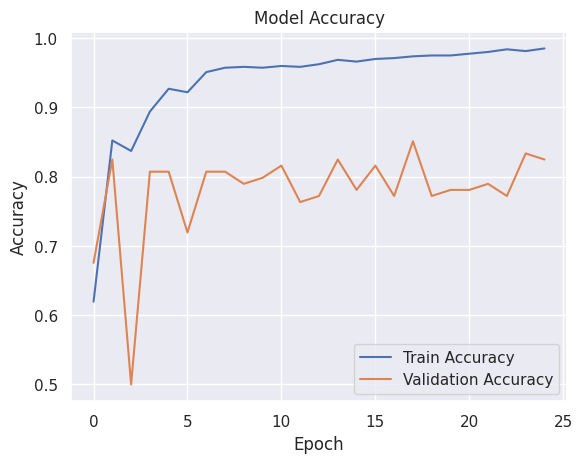

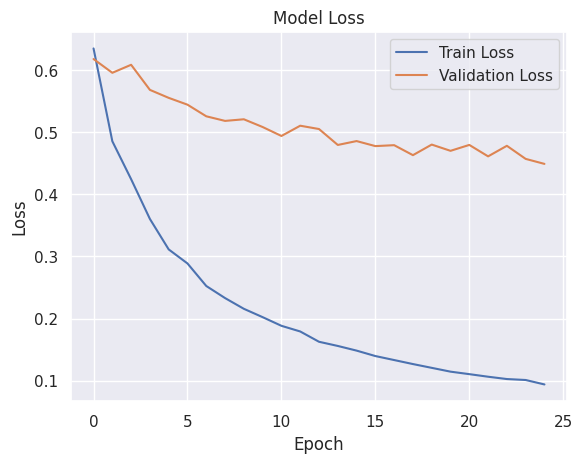

In [8]:
checkpoint_filepath = 'results/best_model_cnn.h5'
custom_learning_rate = 0.000002

# Define data generators for training and testing sets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_shuffle = train_datagen.flow_from_directory(
    params['data'] + '/train',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=True,
)

train_generator = train_datagen.flow_from_directory(
    params['data'] + '/train',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
    params['data'] + '/test',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

val_generator = val_datagen.flow_from_directory(
    params['data'] + '/val',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

with strategy.scope():
    # Model 1: Simple Convolutional Neural Network (CNN)
    model1 = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    # Create an optimizer with the custom learning rate
    custom_optimizer = Adam(learning_rate=custom_learning_rate)

    # Define a ModelCheckpoint callback to save the best model
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',  # You can change this to 'val_accuracy' or another metric
        mode='max',          # Set to 'max' if monitoring accuracy, 'min' if monitoring loss
        verbose=1
    )

    # Compile the model with the custom optimizer
    model1.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    fitted_model1 = model1.fit(train_generator_shuffle, epochs=params['epochs'], validation_data=test_generator, callbacks=[model_checkpoint_callback])

    # Load the best model from the saved checkpoint file
    model1 = models.load_model(checkpoint_filepath)
   
    # Print model evaluation
    print_evaluation(model1, train_generator, test_generator, val_generator)
    
    # Print model evaluation
    plot_evaluation(fitted_model1)

### Transfer Learning with MobileNetV2

Found 791 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.5133
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to results/best_model_mobilenetv2.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 57s 337ms/step - loss: 0.7408 - accuracy: 0.5133 - val_loss: 0.6065 - val_accuracy: 0.6667
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.5651
Epoch 2: val_accuracy improved from 0.66667 to 0.69298, saving model to results/best_model_mobilenetv2.h5
25/25 [==============================] - 7s 271ms/step - loss: 0.7079 - accuracy: 0.5651 - val_loss: 0.5979 - val_accuracy: 0.6930
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.5853
Epoch 3: val_accuracy improved from 0.69298 to 0.70175, saving model to results/best_model_mobilenetv2.h5
25/25 [==============================] - 6s 241ms/step - loss: 0.6713 - accuracy: 0.5853 - val_loss: 0.5900 - val_accuracy: 0.7018
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6498
Epoch 4: val_accuracy improved from 0.70175 to 0.71930, saving model to results/best_model_mobilenetv2.h5
25/25 

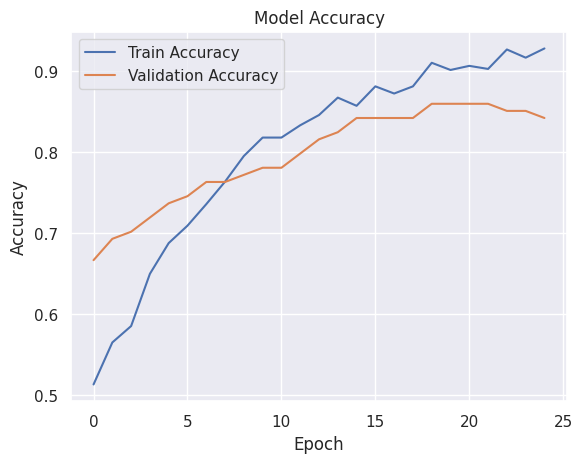

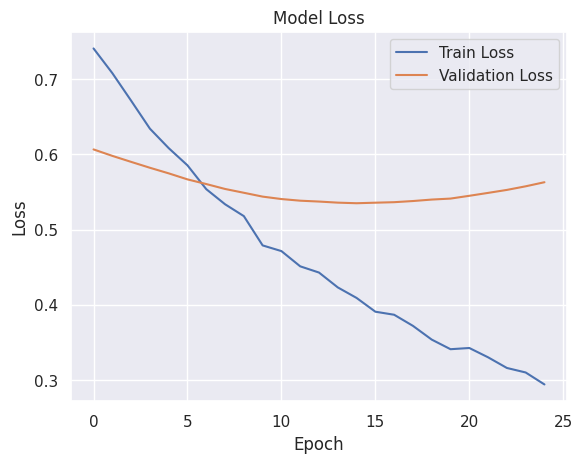

In [13]:
checkpoint_filepath = 'results/best_model_mobilenetv2.h5'
custom_learning_rate = 0.000002

# Define data generators for training and testing sets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_shuffle = train_datagen.flow_from_directory(
    params['data'] + '/train',
    target_size=(224, 224),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=True,
)

train_generator = train_datagen.flow_from_directory(
    params['data'] + '/train',
    target_size=(224, 224),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
    params['data'] + '/test',
    target_size=(224, 224),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

val_generator = val_datagen.flow_from_directory(
    params['data'] + '/val',
    target_size=(224, 224),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

with strategy.scope():
    # Model 2: Transfer Learning with MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')

    model2 = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    # Create an optimizer with the custom learning rate
    custom_optimizer = Adam(learning_rate=custom_learning_rate)

    # Define a ModelCheckpoint callback to save the best model
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',  # You can change this to 'val_accuracy' or another metric
        mode='max',          # Set to 'max' if monitoring accuracy, 'min' if monitoring loss
        verbose=1
    )

    # Compile the model with the custom optimizer
    model2.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    fitted_model2 = model2.fit(train_generator_shuffle, epochs=params['epochs'], validation_data=test_generator, callbacks=[model_checkpoint_callback])

    # Load the best model from the saved checkpoint file
    model2 = models.load_model(checkpoint_filepath)
   
    # Print model evaluation
    print_evaluation(model2, train_generator, test_generator, val_generator)
    
    # Plot model evaluation
    plot_evaluation(fitted_model2)

### Custom CNN with Dropout

In [14]:
checkpoint_filepath = 'results/best_model_cnn_dropout.h5'
custom_learning_rate = 0.00001

# Define data generators for training and testing sets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator_shuffle = train_datagen.flow_from_directory(
    params['data'] + '/train',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=True,
)

train_generator = train_datagen.flow_from_directory(
    params['data'] + '/train',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
    params['data'] + '/test',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

val_generator = val_datagen.flow_from_directory(
    params['data'] + '/val',
    target_size=(img_height, img_width),
    batch_size=params['batch'],
    class_mode='binary',
    shuffle=False,
)

with strategy.scope():
    # Model 3: Custom CNN with Dropout
    model3 = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])

    # Create an optimizer with the custom learning rate
    custom_optimizer = Adam(learning_rate=custom_learning_rate)

    # Define a ModelCheckpoint callback to save the best model
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',  # You can change this to 'val_accuracy' or another metric
        mode='max',          # Set to 'max' if monitoring accuracy, 'min' if monitoring loss
        verbose=1
    )

    # Compile the model with the custom optimizer
    model3.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    fitted_model3 = model3.fit(train_generator_shuffle, epochs=params['epochs'], validation_data=test_generator, callbacks=[model_checkpoint_callback])

    # Load the best model from the saved checkpoint file
    model3 = models.load_model(checkpoint_filepath)

    # Print model evaluation
    print_evaluation(model3, train_generator, test_generator, val_generator)
    
    # Plot model evaluation
    plot_evaluation(fitted_model3)

Found 791 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
Epoch 1/25


2024-01-14 10:30:03.629652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - ETA: 0s - loss: 0.7122 - accuracy: 0.6397
Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to results/best_model_cnn_dropout.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 26s 931ms/step - loss: 0.7122 - accuracy: 0.6397 - val_loss: 0.6172 - val_accuracy: 0.5263
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.8003
Epoch 2: val_accuracy improved from 0.52632 to 0.81579, saving model to results/best_model_cnn_dropout.h5
25/25 [==============================] - 22s 889ms/step - loss: 0.4460 - accuracy: 0.8003 - val_loss: 0.5492 - val_accuracy: 0.8158
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8812
Epoch 3: val_accuracy did not improve from 0.81579
25/25 [==============================] - 16s 612ms/step - loss: 0.3299 - accuracy: 0.8812 - val_loss: 0.5520 - val_accuracy: 0.7719
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.9115
Epoch 4: val_accuracy did not improve from 0.81579
25/25 [==============================] - 16s 611ms/step - loss: 0.2788 - accuracy: 0.9115 - val_loss: 0.5252 - val

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.